# Demo for PAO-ML via e3nn

See also https://docs.e3nn.org/en/latest/guide/convolution.html

## Requirements:
```
pip install --upgrade e3nn matplotlib
```

In [1]:
from pao_file_utils import parse_pao_file, write_pao_file, read_cp2k_energy
import torch
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List
import warnings
t = torch.tensor

In [2]:
# Convenient wrapper that returns torch Tensors
def parse_pao_file_torch(path: Path):
    kinds, atom2kind, coords, xblocks = parse_pao_file(path)
    return kinds, atom2kind, t(coords, dtype=torch.float32), [t(x, dtype=torch.float32) for x in xblocks]

In [3]:
# Load single training sample.
kinds, atom2kind, coords, xblocks = parse_pao_file_torch(Path("./2H2O_rotations/phi_00/2H2O_pao44-1_0.pao"))

In [4]:
TRAINING_KIND = "O" # The atom kinds for which we're training.
TRAINING_ATOMS = [i for i, kind in enumerate(atom2kind) if kind == TRAINING_KIND]
assert all(atom2kind[i]  == TRAINING_KIND for i in TRAINING_ATOMS)

In [5]:
# Irreps of input features, i.e. the descriptor.
irreps_features = o3.Irreps("2x0e") # features: is_hydrogen, is_oxygen

In [6]:
# Irreps of primary basis.
pao_basis_size = 4
prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
}
irreps_prim_basis = o3.Irreps(prim_basis_specs[TRAINING_KIND])
prim_basis_size = irreps_prim_basis.dim
for iatom in TRAINING_ATOMS:
    assert xblocks[iatom].shape[0] == pao_basis_size
    assert xblocks[iatom].shape[1] == prim_basis_size

In [7]:
# Helper function to turn an Irreps object into a list of individual Irrep objects.
def flatten_irreps(irreps: o3.Irreps) -> List[o3.Irrep]:
    result = []
    for mul, ir in irreps:
        result += mul * [ir]
    return result

flat_irreps_prim_basis = flatten_irreps(irreps_prim_basis)

In [8]:
# Irreps of auxilary Hamiltonian.
irreps_aux =  o3.Irreps()
for i, a in enumerate(flat_irreps_prim_basis):
    for j, b in enumerate(flat_irreps_prim_basis):
        if j > i:
            continue # skip upper triangle
        irreps_aux += a *  b

In [9]:
# Irreps of Spherical Harmonics used for sensing neighbors.
irreps_sensing = o3.Irreps.spherical_harmonics(lmax=irreps_aux.lmax)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

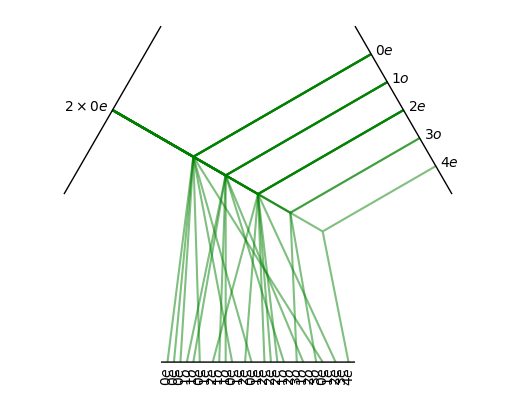

In [10]:
# Tensor Product
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    tp = o3.FullyConnectedTensorProduct(irreps_features, irreps_sensing, irreps_aux, shared_weights=False)
#print(tp.weight_numel)
tp.visualize()

In [11]:
# Perceptron
num_distances = 10
num_layers = 16
# Note ReLu does not work well because many of the distance buckets from soft_one_hot_linspace are zero.
fc = nn.FullyConnectedNet([num_distances, num_layers, tp.weight_numel], torch.sigmoid) # relu does not 
print("Number of parameters: ", sum(p.numel() for p in fc.parameters()))

Number of parameters:  864


In [12]:
# The input of each node is whether it's an oxygen or not.
num_neighbors = 6 # TODO: Remove the central atom, it doesn't carry any information.
assert coords.shape[0] == num_neighbors
features = t([(k=="H", k=="O") for k in atom2kind], dtype=torch.float32).mul(num_neighbors**0.5)
assert features.shape[0] == num_neighbors and features.shape[1] == irreps_features.dim

In [13]:
# CP2K uses the yzx convention, while e3nn uses xyz.
# https://docs.e3nn.org/en/stable/guide/change_of_basis.html
change_of_coord = torch.tensor([[0., 0., 1.],[1., 0., 0.],[0., 1., 0.]]) # yzx -> xyz
D = irreps_prim_basis.D_from_matrix(change_of_coord)

In [14]:
def build_h_aux_matrix(vec_aux):
    assert vec_aux.dim() == 1 and vec_aux.shape[0] == irreps_aux.dim
    h_aux = torch.eye(prim_basis_size, dtype=torch.float32)
    offset_c = 0
    for i, a in enumerate(flat_irreps_prim_basis):
        offset_a = sum(ir.dim for ir in flat_irreps_prim_basis[:i])
        for j, b in enumerate(flat_irreps_prim_basis):
            if j > i:
                continue # skip upper triangle
            offset_b = sum(ir.dim for ir in flat_irreps_prim_basis[:j])
            flat_irreps_prod = flatten_irreps(o3.Irreps(a * b))
            for c in flat_irreps_prod:
                if c.l < abs(a.l - b.l) or a.l + b.l < c.l:
                    continue
                # TODO the wigner blocks are mostly zeros - not sure pytorch takes advantage of that.
                wigner_block = o3.wigner_3j(a.l, b.l, c.l)
                h_block = wigner_block @ vec_aux[offset_c:offset_c+c.dim]
                h_aux[offset_a:offset_a+a.dim, offset_b:offset_b+b.dim] += h_block
                offset_c += c.dim
    return h_aux

In [15]:
# Prepare model and loss function.
max_radius = 6.0 # TODO tune

def loss_function(pred, label):
    p1 = pred.T @ pred
    p2 = label.T @ label # is a projector because labels are orthonormal
    return (p1 - p2).pow(2).sum()
            
def model(dir_vec):
    sh = o3.spherical_harmonics(irreps_sensing, dir_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(dir_vec.norm(dim=1), 0.0, max_radius, num_distances,
                                basis='smooth_finite', cutoff=True).mul(num_distances**0.5)
    h_aux_vec = tp(features, sh, fc(emb)).sum(dim=0).div(num_neighbors**0.5)
    h_aux_matrix = build_h_aux_matrix(h_aux_vec)
    _, u_matrix = torch.linalg.eigh(h_aux_matrix)
    output = torch.zeros([pao_basis_size, prim_basis_size])
    for i in range(pao_basis_size):
        output[i, :] = u_matrix[:, i] @ D  # go from yzx -> xyz
    return output

In [16]:
# Prepare features and labels.
def labelfy(xblock):
    # The loss_functions requires orthonormal labels.
    U, S, Vh = torch.linalg.svd(xblock, full_matrices=False)
    return Vh

labels = [labelfy(xblocks[i]) for i in TRAINING_ATOMS]
edge_vecs = [coords - coords[i] for i in TRAINING_ATOMS]

In [17]:
optim = torch.optim.Adam(fc.parameters())
num_steps = 10001
for step in range(num_steps):
    optim.zero_grad()
    loss_values = ""
    for edge_vec, label in zip(edge_vecs, labels):
        pred = model(edge_vec)
        loss = loss_function(pred, label)
        loss.backward()
        loss_values += (f"  {loss:.8e}")
    if step % 1000 == 0:
        print(f"training {step:5d} | loss {loss_values}")
    optim.step()

training     0 | loss   2.10838628e+00  3.07193351e+00
training  1000 | loss   1.83711257e-02  8.38373881e-03
training  2000 | loss   4.29785298e-03  1.30085344e-03
training  3000 | loss   1.93590648e-03  3.02339176e-04
training  4000 | loss   8.59358814e-04  1.46036749e-04
training  5000 | loss   2.49066914e-04  7.00441014e-05
training  6000 | loss   6.45721520e-05  3.34074211e-05
training  7000 | loss   3.53589785e-05  2.05165161e-05
training  8000 | loss   2.76582032e-05  1.43015650e-05
training  9000 | loss   2.19096655e-05  9.87502881e-06
training 10000 | loss   1.63419954e-05  6.77372827e-06


# Validation

In [18]:
# Test against rotated training samples using loss functions
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao"))[:10]:
    _, _, test_coords, test_xblocks = parse_pao_file_torch(path)
    for i in TRAINING_ATOMS:
        edge_vec = test_coords - test_coords[i]
        test_loss = loss_function(model(edge_vec), labelfy(test_xblocks[i]))
        print(f"{path}: atom: {i} lost: {test_loss:e}")

2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: atom: 0 lost: 2.011096e-05
2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: atom: 3 lost: 1.219755e-05
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: atom: 0 lost: 1.852550e-05
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: atom: 3 lost: 9.257299e-06
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: atom: 0 lost: 3.234067e-05
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: atom: 3 lost: 1.573492e-05
2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: atom: 0 lost: 1.909654e-05
2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: atom: 3 lost: 7.186384e-06
2H2O_rotations/rand_04/2H2O_pao44-1_0.pao: atom: 0 lost: 2.419025e-05
2H2O_rotations/rand_04/2H2O_pao44-1_0.pao: atom: 3 lost: 1.945070e-05
2H2O_rotations/rand_05/2H2O_pao44-1_0.pao: atom: 0 lost: 2.272514e-05
2H2O_rotations/rand_05/2H2O_pao44-1_0.pao: atom: 3 lost: 1.275862e-05
2H2O_rotations/rand_06/2H2O_pao44-1_0.pao: atom: 0 lost: 2.346612e-05
2H2O_rotations/rand_06/2H2O_pao44-1_0.pao: atom: 3 lost: 1.007000e-05
2H2O_rotations/rand_

In [19]:
# Test against randomly rotated training samples using CP2K.
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao"))[:10]:
    _, _, sample_coords, sample_xblocks = parse_pao_file_torch(path)
    pred_xblocks = sample_xblocks.copy()
    for i in TRAINING_ATOMS:
        edge_vec = sample_coords - sample_coords[i]
        pred_xblocks[i] = model(edge_vec)
    write_pao_file(path.parent / "2H2O_pao44_eval.pao", kinds, atom2kind, sample_coords, pred_xblocks)
    ! cd {path.parent}; OMP_NUM_THREADS=8 ~/git/cp2k/exe/local/cp2k.sdbg 2H2O_pao44_eval.inp > 2H2O_pao44_eval.out
    test_energy = read_cp2k_energy(path.parent / "2H2O_pao44_eval.out")
    ref_energy = read_cp2k_energy(path.parent / "2H2O_pao44.out")
    rel_diff_energy = (test_energy - ref_energy) / ref_energy
    print(f"{path}: Relative Energy Diff: {rel_diff_energy:e}")

2H2O_rotations/rand_00/2H2O_pao44-1_0.pao: Relative Energy Diff: -9.160514e-07
2H2O_rotations/rand_01/2H2O_pao44-1_0.pao: Relative Energy Diff: -8.431742e-07
2H2O_rotations/rand_02/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.116630e-06
2H2O_rotations/rand_03/2H2O_pao44-1_0.pao: Relative Energy Diff: -8.333969e-07
2H2O_rotations/rand_04/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.085250e-06
2H2O_rotations/rand_05/2H2O_pao44-1_0.pao: Relative Energy Diff: -9.382243e-07
2H2O_rotations/rand_06/2H2O_pao44-1_0.pao: Relative Energy Diff: -9.366634e-07
2H2O_rotations/rand_07/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.018164e-06
2H2O_rotations/rand_08/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.030983e-06
2H2O_rotations/rand_09/2H2O_pao44-1_0.pao: Relative Energy Diff: -1.052002e-06
